# Granger Causality Analysis of Picnic Basket Components (VWAP Version)

This notebook performs Granger causality tests on all products that make up the picnic baskets to identify potential causal relationships between them. This version uses VWAP instead of mid prices and implements a rolling linear regression-based purification process.

## Picnic Basket Compositions:
- PICNIC_BASKET1 = 6 × CROISSANTS + 3 × JAMS + 1 × DJEMBE
- PICNIC_BASKET2 = 4 × CROISSANTS + 2 × JAMS

In [2]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Data Loading

First, we'll load the price data for all products that make up the picnic baskets.

In [3]:
# Add the parent directory to the path to import backtester
sys.path.append(os.path.abspath('../../'))

# Try to import the backtester package
try:
    from backtester import get_price_data
    print("Successfully imported backtester.get_price_data")
except ImportError:
    print("Could not import backtester. Trying alternative method...")
    
    # Define a function to load price data from CSV files
    def load_price_data(round_num, day_num):
        # Path to data directory
        data_path = '../../../Prosperity 3 Data'
        
        # Construct file path
        file_path = os.path.join(data_path, f'Round {round_num}/prices_round_{round_num}_day_{day_num}.csv')
        
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return pd.DataFrame()
        
        # Load data
        data = pd.read_csv(file_path, sep=';')
        
        return data
    
    def get_price_data(product, round_num):
        all_data = pd.DataFrame()
        
        for day in range(-2, 1):
            try:
                data = load_price_data(round_num, day)
                if not data.empty:
                    # Adjust timestamp to create a continuous series
                    data['timestamp'] += (day + 2) * 1000000
                    all_data = pd.concat([all_data, data])
            except Exception as e:
                print(f"Error loading data for day {day}: {e}")
        
        return all_data

Successfully imported backtester.get_price_data


In [4]:
# Define the products we want to analyze
products = ['CROISSANTS', 'JAMS', 'DJEMBES', 'PICNIC_BASKET1', 'PICNIC_BASKET2']

# Load data for each product
product_data = {}

for product in products:
    try:
        data = get_price_data(product, 2)  # Round 2 data
        if not data.empty:
            product_data[product] = data
            print(f"Loaded {len(data)} rows of {product} data")
        else:
            print(f"No data found for {product}")
    except Exception as e:
        print(f"Error loading {product} data: {e}")

Loading real data for CROISSANTS from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of CROISSANTS data
Loading real data for JAMS from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_0.csv
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_1.csv
Successfully loaded real data with 30000 rows
Loaded 30000 rows of JAMS data
Loading real data for DJEMBES from round 2...
Data for Round 2, Day -2 not found. Skipping.
Found data file at ../../../Prosperity 3 Data/Round 2/prices_round_2_day_-1.csv
Found da

In [5]:
# Extract VWAP and create a combined DataFrame
prices_df = pd.DataFrame()

for product, data in product_data.items():
    if not data.empty:
        # Check if 'vwap' column exists
        if 'vwap' in data.columns:
            # Extract timestamp and vwap
            product_prices = data.reset_index()[['timestamp', 'vwap']].copy()
            product_prices.columns = ['timestamp', product]
            
            # Merge with the combined DataFrame
            if prices_df.empty:
                prices_df = product_prices
            else:
                prices_df = pd.merge(prices_df, product_prices, on='timestamp', how='outer')
        else:
            print(f"Warning: 'vwap' column not found in {product} data")

# Sort by timestamp
if not prices_df.empty:
    prices_df = prices_df.sort_values('timestamp')
    prices_df = prices_df.set_index('timestamp')
    
    # Display the first few rows
    print("Combined price data:")
    display(prices_df.head())
    
    # Display basic statistics
    print("\nBasic statistics:")
    display(prices_df.describe())
    
    # Check for missing values
    print("\nMissing values per column:")
    display(prices_df.isna().sum())
    
    # Create purified versions of the picnic baskets (removing the effect of their components)
    print("\nCreating purified versions of the picnic baskets using rolling linear regression...")
    
    # Make sure we have all the necessary components
    required_components = ['CROISSANTS', 'JAMS', 'DJEMBES']
    missing_components = [comp for comp in required_components if comp not in prices_df.columns]
    
    if not missing_components:
        # First calculate log returns for all products
        log_returns_df = np.log(prices_df).diff().dropna()
        
        # Create a copy of the log returns DataFrame for the purified data
        purified_returns_df = log_returns_df.copy()
        
        # Define a function to perform rolling linear regression
        def rolling_linear_regression(y, X, window_size=50):
            """
            Perform rolling linear regression and return residuals.
            
            Parameters:
            - y: Series with target variable (basket returns)
            - X: DataFrame with predictor variables (component returns)
            - window_size: Size of the rolling window
            
            Returns:
            - Series with residuals (purified returns)
            """
            from sklearn.linear_model import LinearRegression
            import numpy as np
            
            # Initialize residuals series with NaN values
            residuals = pd.Series(np.nan, index=y.index)
            
            # Ensure we have enough data points
            if len(y) <= window_size:
                print(f"Warning: Not enough data points for rolling regression. Using static regression instead.")
                # Fit a single regression model on all available data
                model = LinearRegression()
                model.fit(X, y)
                predicted = model.predict(X)
                residuals = y - predicted
                return residuals
            
            # Perform rolling regression
            for i in range(window_size, len(y)):
                # Get the window of data
                y_window = y.iloc[i-window_size:i]
                X_window = X.iloc[i-window_size:i]
                
                # Fit the model
                model = LinearRegression()
                model.fit(X_window, y_window)
                
                # Predict the current value
                X_current = X.iloc[i:i+1]
                predicted = model.predict(X_current)[0]
                
                # Calculate residual
                residuals.iloc[i] = y.iloc[i] - predicted
            
            return residuals
        
        # PICNIC_BASKET1 = 6 × CROISSANTS + 3 × JAMS + 1 × DJEMBE
        if 'PICNIC_BASKET1' in purified_returns_df.columns:
            # Prepare data for regression
            basket1_returns = purified_returns_df['PICNIC_BASKET1']
            components1 = purified_returns_df[['CROISSANTS', 'JAMS', 'DJEMBES']]
            
            # Perform rolling linear regression
            print("Performing rolling linear regression for PICNIC_BASKET1...")
            purified_returns_df['PICNIC_BASKET1_PURIFIED'] = rolling_linear_regression(basket1_returns, components1)
            print("Created PICNIC_BASKET1_PURIFIED")
        
        # PICNIC_BASKET2 = 4 × CROISSANTS + 2 × JAMS
        if 'PICNIC_BASKET2' in purified_returns_df.columns:
            # Prepare data for regression
            basket2_returns = purified_returns_df['PICNIC_BASKET2']
            components2 = purified_returns_df[['CROISSANTS', 'JAMS']]
            
            # Perform rolling linear regression
            print("Performing rolling linear regression for PICNIC_BASKET2...")
            purified_returns_df['PICNIC_BASKET2_PURIFIED'] = rolling_linear_regression(basket2_returns, components2)
            print("Created PICNIC_BASKET2_PURIFIED")
        
        # Remove the original picnic baskets from the analysis
        if 'PICNIC_BASKET1' in purified_returns_df.columns:
            purified_returns_df = purified_returns_df.drop('PICNIC_BASKET1', axis=1)
        if 'PICNIC_BASKET2' in purified_returns_df.columns:
            purified_returns_df = purified_returns_df.drop('PICNIC_BASKET2', axis=1)
        
        # Display the first few rows of the purified data
        print("\nPurified returns data:")
        display(purified_returns_df.head())
        
        # Use the purified returns data for analysis
        log_returns_df = purified_returns_df
    else:
        print(f"Cannot create purified baskets. Missing components: {missing_components}")
else:
    print("No price data available for analysis")

Combined price data:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2
timestamp,,,,,
0,4304.5,6670.5,13450.500000,59289.236842,30609.000000
100,4304.5,6670.5,13450.000000,59287.472973,30612.729730
200,4304.5,6671.0,13450.196078,59293.500000,30614.696970
300,4304.5,6672.0,13450.000000,59293.500000,30620.302326
400,4305.5,6672.0,13452.500000,59291.779412,30622.312500



Basic statistics:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1,PICNIC_BASKET2
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,4297.842360,6593.315687,13436.233067,59051.991852,30408.240942
std,23.777760,59.546051,42.950624,363.666332,214.973921
min,4251.000000,6498.500000,13353.000000,58397.500000,29987.326531
25%,4274.176618,6529.000000,13395.500000,58678.500000,30236.338816
50%,4304.500000,6610.000000,13444.500000,59142.500000,30426.292560
75%,4318.779070,6636.500000,13470.162419,59335.625000,30589.663288
max,4340.500000,6702.500000,13519.500000,59786.500000,30813.000000



Missing values per column:


CROISSANTS        0
JAMS              0
DJEMBES           0
PICNIC_BASKET1    0
PICNIC_BASKET2    0
dtype: int64


Creating purified versions of the picnic baskets using rolling linear regression...
Performing rolling linear regression for PICNIC_BASKET1...
Created PICNIC_BASKET1_PURIFIED
Performing rolling linear regression for PICNIC_BASKET2...
Created PICNIC_BASKET2_PURIFIED

Purified returns data:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1_PURIFIED,PICNIC_BASKET2_PURIFIED
timestamp,,,,,
100,0.000000,0.000000,-0.000037,NaN,NaN
200,0.000000,0.000075,0.000015,NaN,NaN
300,0.000000,0.000150,-0.000015,NaN,NaN
400,0.000232,0.000000,0.000186,NaN,NaN
500,0.000000,0.000000,0.000074,NaN,NaN


In [17]:
round(purified_returns_df.corr(),2)

,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1_PURIFIED,PICNIC_BASKET2_PURIFIED
CROISSANTS,1.00,0.01,0.01,0.01,0.02
JAMS,0.01,1.00,-0.01,0.01,0.01
DJEMBES,0.01,-0.01,1.00,0.00,-0.01
PICNIC_BASKET1_PURIFIED,0.01,0.01,0.00,1.00,0.08
PICNIC_BASKET2_PURIFIED,0.02,0.01,-0.01,0.08,1.00


In [6]:
# If we haven't already calculated log returns (in case purification wasn't done)
if 'log_returns_df' not in locals():
    # Calculate log returns for each product
    log_returns_df = np.log(prices_df).diff().dropna()

# Display the first few rows of log returns
print("Log returns:")
display(log_returns_df.head())

Log returns:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1_PURIFIED,PICNIC_BASKET2_PURIFIED
timestamp,,,,,
100,0.000000,0.000000,-0.000037,NaN,NaN
200,0.000000,0.000075,0.000015,NaN,NaN
300,0.000000,0.000150,-0.000015,NaN,NaN
400,0.000232,0.000000,0.000186,NaN,NaN
500,0.000000,0.000000,0.000074,NaN,NaN


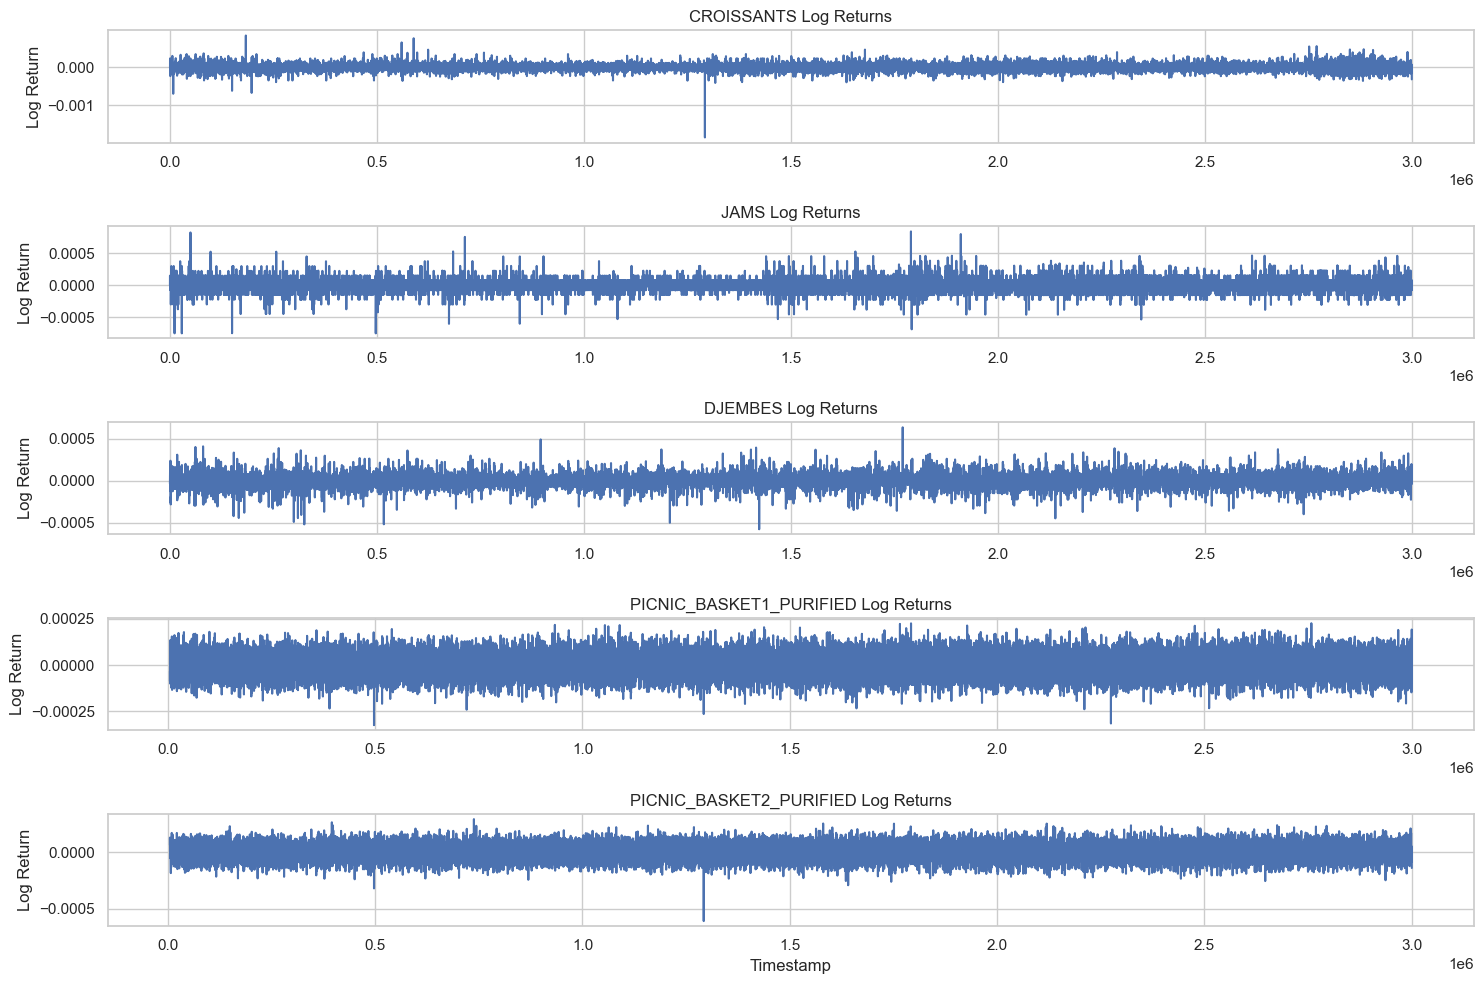

In [7]:
# Plot the log returns for each product
plt.figure(figsize=(15, 10))

for i, product in enumerate(log_returns_df.columns, 1):
    plt.subplot(len(log_returns_df.columns), 1, i)
    plt.plot(log_returns_df.index, log_returns_df[product])
    plt.title(f'{product} Log Returns')
    plt.ylabel('Log Return')
    if i == len(log_returns_df.columns):  # Only add x-label for the bottom plot
        plt.xlabel('Timestamp')

plt.tight_layout()
plt.show()

In [8]:
# Function to perform ADF test and interpret results
def adf_test(series, product_name):
    result = adfuller(series.dropna())
    
    # Extract and format the results
    adf_stat = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print the results
    print(f'ADF Test for {product_name}')
    print(f'ADF Statistic: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'\t{key}: {value:.4f}')
    
    # Interpret the results
    if p_value <= 0.05:
        print('Conclusion: The series is stationary (reject H0)')
    else:
        print('Conclusion: The series is non-stationary (fail to reject H0)')
    
    print('\n')
    
    return p_value <= 0.05  # Return True if stationary

# Test stationarity for each product's log returns
stationarity_results = {}

for product in log_returns_df.columns:
    stationarity_results[product] = adf_test(log_returns_df[product], product)

ADF Test for CROISSANTS
ADF Statistic: -84.6234
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for JAMS
ADF Statistic: -39.4462
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for DJEMBES
ADF Statistic: -117.2968
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for PICNIC_BASKET1_PURIFIED
ADF Statistic: -33.3888
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)


ADF Test for PICNIC_BASKET2_PURIFIED
ADF Statistic: -33.8297
p-value: 0.0000
Critical Values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Conclusion: The series is stationary (reject H0)




In [9]:
# Function to perform Granger causality test and extract p-values
def perform_granger_test(data, x_var, y_var, max_lag):
    """
    Test if x_var Granger-causes y_var.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the variables
    x_var (str): Name of the potential causal variable
    y_var (str): Name of the potential effect variable
    max_lag (int): Maximum number of lags to test
    
    Returns:
    dict: Dictionary of p-values for each lag
    """
    # Create a DataFrame with the two variables (y_var must be first)
    test_df = data[[y_var, x_var]].dropna()
    
    # Skip if not enough data points
    if len(test_df) <= max_lag + 1:
        print(f'Not enough data points for {x_var} -> {y_var} with max_lag={max_lag}')
        return {i: 1.0 for i in range(1, max_lag + 1)}  # Return p-value of 1.0 (no causality)
    
    # Perform the Granger causality test
    try:
        test_result = grangercausalitytests(test_df, maxlag=max_lag, verbose=False)
        
        # Extract p-values (using Wald test)
        p_values = {lag: round(result[0]['ssr_ftest'][1], 4) for lag, result in test_result.items()}
        
        return p_values
    except Exception as e:
        print(f'Error in Granger test for {x_var} -> {y_var}: {e}')
        return {i: 1.0 for i in range(1, max_lag + 1)}  # Return p-value of 1.0 (no causality)

# Set the maximum lag for Granger causality tests
max_lag = 5

# Create a dictionary to store the results
granger_results = {}

# Perform Granger causality tests for all pairs of products
for x_var in log_returns_df.columns:
    granger_results[x_var] = {}
    
    for y_var in log_returns_df.columns:
        if x_var != y_var:  # Skip self-causality
            print(f'Testing if {x_var} Granger-causes {y_var}...')
            p_values = perform_granger_test(log_returns_df, x_var, y_var, max_lag)
            
            # Store the minimum p-value across all lags
            min_p_value = min(p_values.values())
            min_lag = min([lag for lag, p in p_values.items() if p == min_p_value])
            
            granger_results[x_var][y_var] = {
                'p_values': p_values,
                'min_p_value': min_p_value,
                'min_lag': min_lag,
                'significant': min_p_value <= 0.05  # Using 5% significance level
            }
            
            # Print the result
            if min_p_value <= 0.05:
                print(f'  Result: {x_var} Granger-causes {y_var} with p-value {min_p_value:.4f} at lag {min_lag}')
            else:
                print(f'  Result: No significant Granger causality from {x_var} to {y_var} (min p-value: {min_p_value:.4f})')
            
            print()  # Add a blank line for readability

Testing if CROISSANTS Granger-causes JAMS...
  Result: No significant Granger causality from CROISSANTS to JAMS (min p-value: 0.5251)

Testing if CROISSANTS Granger-causes DJEMBES...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: No significant Granger causality from CROISSANTS to DJEMBES (min p-value: 0.2536)

Testing if CROISSANTS Granger-causes PICNIC_BASKET1_PURIFIED...
  Result: CROISSANTS Granger-causes PICNIC_BASKET1_PURIFIED with p-value 0.0000 at lag 1

Testing if CROISSANTS Granger-causes PICNIC_BASKET2_PURIFIED...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: CROISSANTS Granger-causes PICNIC_BASKET2_PURIFIED with p-value 0.0000 at lag 1

Testing if JAMS Granger-causes CROISSANTS...
  Result: No significant Granger causality from JAMS to CROISSANTS (min p-value: 0.1629)

Testing if JAMS Granger-causes DJEMBES...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: No significant Granger causality from JAMS to DJEMBES (min p-value: 0.0965)

Testing if JAMS Granger-causes PICNIC_BASKET1_PURIFIED...
  Result: JAMS Granger-causes PICNIC_BASKET1_PURIFIED with p-value 0.0000 at lag 1

Testing if JAMS Granger-causes PICNIC_BASKET2_PURIFIED...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: JAMS Granger-causes PICNIC_BASKET2_PURIFIED with p-value 0.0000 at lag 1

Testing if DJEMBES Granger-causes CROISSANTS...
  Result: No significant Granger causality from DJEMBES to CROISSANTS (min p-value: 0.0660)

Testing if DJEMBES Granger-causes JAMS...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: DJEMBES Granger-causes JAMS with p-value 0.0043 at lag 3

Testing if DJEMBES Granger-causes PICNIC_BASKET1_PURIFIED...
  Result: No significant Granger causality from DJEMBES to PICNIC_BASKET1_PURIFIED (min p-value: 0.0548)

Testing if DJEMBES Granger-causes PICNIC_BASKET2_PURIFIED...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: No significant Granger causality from DJEMBES to PICNIC_BASKET2_PURIFIED (min p-value: 0.7235)

Testing if PICNIC_BASKET1_PURIFIED Granger-causes CROISSANTS...
  Result: PICNIC_BASKET1_PURIFIED Granger-causes CROISSANTS with p-value 0.0000 at lag 1

Testing if PICNIC_BASKET1_PURIFIED Granger-causes JAMS...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: PICNIC_BASKET1_PURIFIED Granger-causes JAMS with p-value 0.0000 at lag 1

Testing if PICNIC_BASKET1_PURIFIED Granger-causes DJEMBES...
  Result: No significant Granger causality from PICNIC_BASKET1_PURIFIED to DJEMBES (min p-value: 0.5468)

Testing if PICNIC_BASKET1_PURIFIED Granger-causes PICNIC_BASKET2_PURIFIED...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: PICNIC_BASKET1_PURIFIED Granger-causes PICNIC_BASKET2_PURIFIED with p-value 0.0018 at lag 1

Testing if PICNIC_BASKET2_PURIFIED Granger-causes CROISSANTS...
  Result: PICNIC_BASKET2_PURIFIED Granger-causes CROISSANTS with p-value 0.0000 at lag 1

Testing if PICNIC_BASKET2_PURIFIED Granger-causes JAMS...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: PICNIC_BASKET2_PURIFIED Granger-causes JAMS with p-value 0.0000 at lag 1

Testing if PICNIC_BASKET2_PURIFIED Granger-causes DJEMBES...
  Result: No significant Granger causality from PICNIC_BASKET2_PURIFIED to DJEMBES (min p-value: 0.3707)

Testing if PICNIC_BASKET2_PURIFIED Granger-causes PICNIC_BASKET1_PURIFIED...


c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\fujos\anaconda3\envs\prosperity\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  Result: PICNIC_BASKET2_PURIFIED Granger-causes PICNIC_BASKET1_PURIFIED with p-value 0.0001 at lag 1



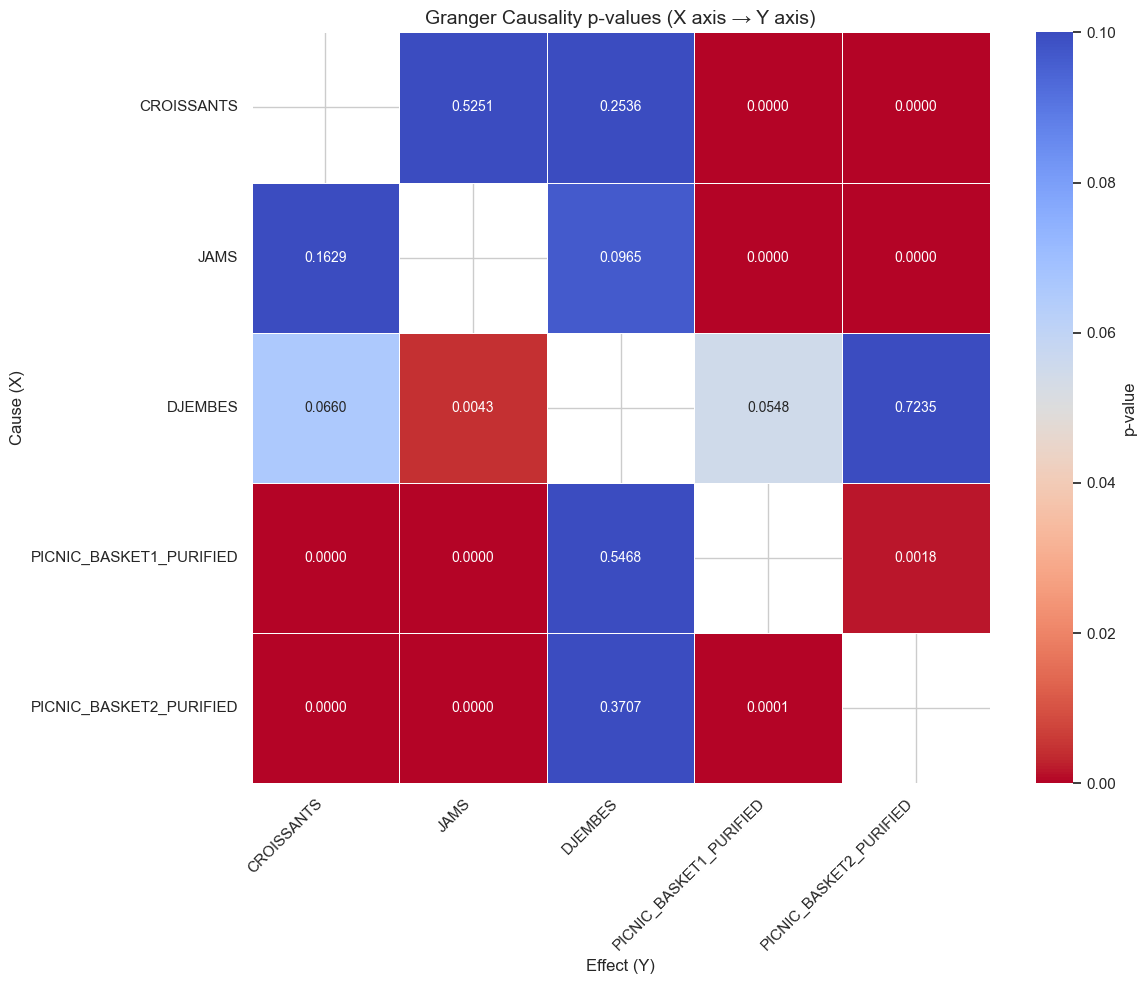

In [10]:
# Create a matrix of p-values for heatmap visualization
p_value_matrix = pd.DataFrame(index=log_returns_df.columns, columns=log_returns_df.columns)

for x_var in log_returns_df.columns:
    for y_var in log_returns_df.columns:
        if x_var == y_var:
            p_value_matrix.loc[x_var, y_var] = 1.0  # Self-causality is not tested
        else:
            p_value_matrix.loc[x_var, y_var] = granger_results[x_var][y_var]['min_p_value']

# Convert all values to float to avoid TypeError
p_value_matrix = p_value_matrix.astype(float)

# Create a heatmap of p-values
plt.figure(figsize=(12, 10))

# Mask the diagonal (self-causality) for better visualization
mask = np.zeros_like(p_value_matrix, dtype=bool)
np.fill_diagonal(mask, True)

# Create the heatmap with improved formatting
sns.heatmap(p_value_matrix, annot=True, cmap='coolwarm_r', vmin=0, vmax=0.1, 
           linewidths=0.5, cbar_kws={'label': 'p-value'}, mask=mask, 
           annot_kws={'size': 10}, fmt='.4f')
plt.title('Granger Causality p-values (X axis → Y axis)', fontsize=14)
plt.xlabel('Effect (Y)', fontsize=12)
plt.ylabel('Cause (X)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

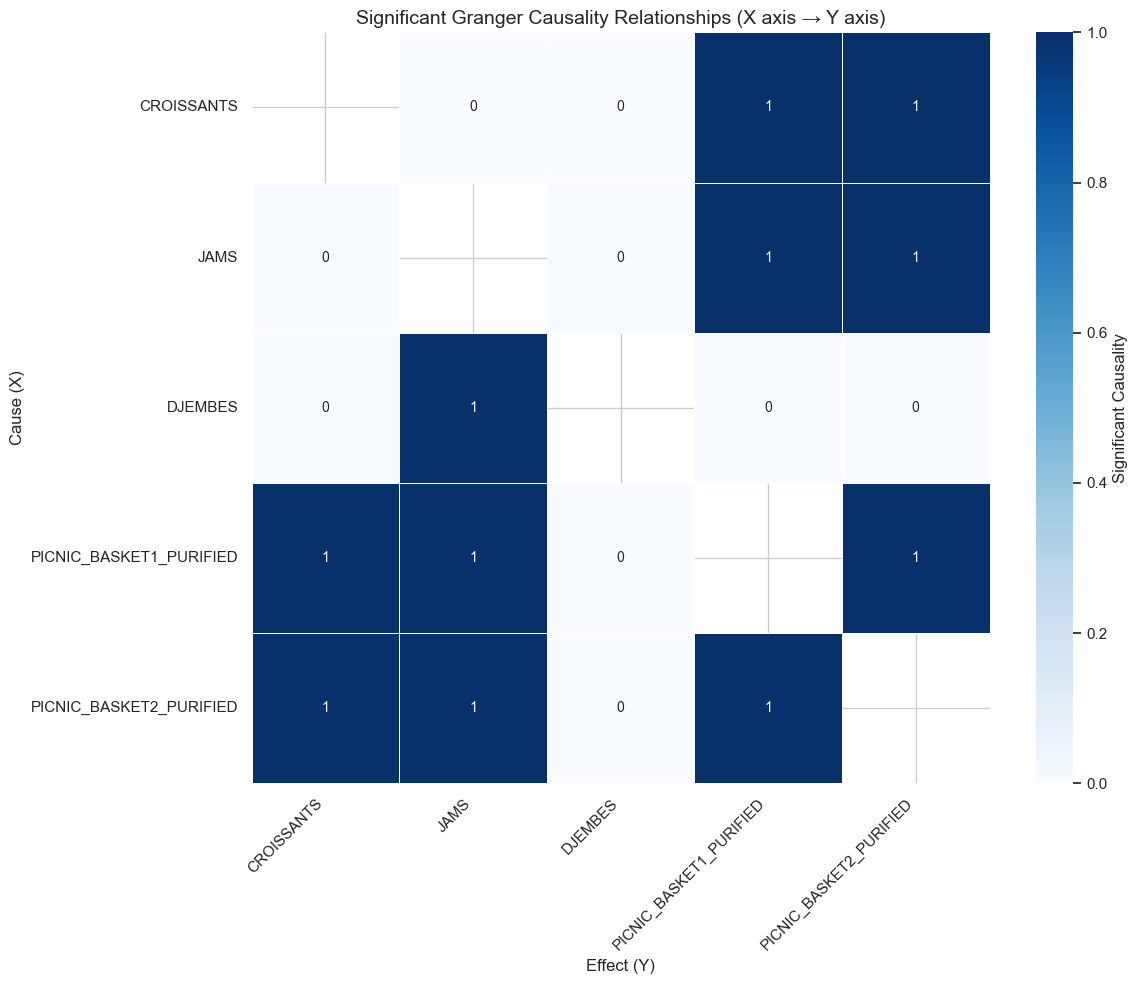

In [11]:
# Create a binary matrix of significant Granger causality relationships
significance_matrix = p_value_matrix <= 0.05

plt.figure(figsize=(12, 10))

# Create the significance heatmap with improved formatting
sns.heatmap(significance_matrix.astype(int), annot=True, cmap='Blues', vmin=0, vmax=1, 
           linewidths=0.5, cbar_kws={'label': 'Significant Causality'}, mask=mask,
           annot_kws={'size': 10}, fmt='d')
plt.title('Significant Granger Causality Relationships (X axis → Y axis)', fontsize=14)
plt.xlabel('Effect (Y)', fontsize=12)
plt.ylabel('Cause (X)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# Create a summary of significant relationships
significant_relationships = []

for x_var in log_returns_df.columns:
    for y_var in log_returns_df.columns:
        if x_var != y_var and granger_results[x_var][y_var]['significant']:
            significant_relationships.append({
                'Cause': x_var,
                'Effect': y_var,
                'p-value': granger_results[x_var][y_var]['min_p_value'],
                'Lag': granger_results[x_var][y_var]['min_lag']
            })

# Convert to DataFrame and sort by p-value
if significant_relationships:
    summary_df = pd.DataFrame(significant_relationships)
    summary_df = summary_df.sort_values('p-value')
    
    print('Significant Granger Causality Relationships:')
    display(summary_df)
else:
    print('No significant Granger causality relationships found.')

Significant Granger Causality Relationships:


,Cause,Effect,p-value,Lag
0,CROISSANTS,PICNIC_BASKET1_PURIFIED,0.0000,1
1,CROISSANTS,PICNIC_BASKET2_PURIFIED,0.0000,1
2,JAMS,PICNIC_BASKET1_PURIFIED,0.0000,1
3,JAMS,PICNIC_BASKET2_PURIFIED,0.0000,1
5,PICNIC_BASKET1_PURIFIED,CROISSANTS,0.0000,1
6,PICNIC_BASKET1_PURIFIED,JAMS,0.0000,1
8,PICNIC_BASKET2_PURIFIED,CROISSANTS,0.0000,1
9,PICNIC_BASKET2_PURIFIED,JAMS,0.0000,1
10,PICNIC_BASKET2_PURIFIED,PICNIC_BASKET1_PURIFIED,0.0001,1
7,PICNIC_BASKET1_PURIFIED,PICNIC_BASKET2_PURIFIED,0.0018,1


In [13]:
# Count the number of significant relationships for each product as cause and effect
cause_counts = {product: 0 for product in log_returns_df.columns}
effect_counts = {product: 0 for product in log_returns_df.columns}

for relationship in significant_relationships:
    cause_counts[relationship['Cause']] += 1
    effect_counts[relationship['Effect']] += 1

# Create a DataFrame of counts
counts_df = pd.DataFrame({
    'As Cause': cause_counts,
    'As Effect': effect_counts
}).T

print('\nNumber of significant relationships for each product:')
display(counts_df)


Number of significant relationships for each product:


,CROISSANTS,JAMS,DJEMBES,PICNIC_BASKET1_PURIFIED,PICNIC_BASKET2_PURIFIED
As Cause,2,2,1,3,3
As Effect,2,3,0,3,3


<Figure size 1200x600 with 0 Axes>

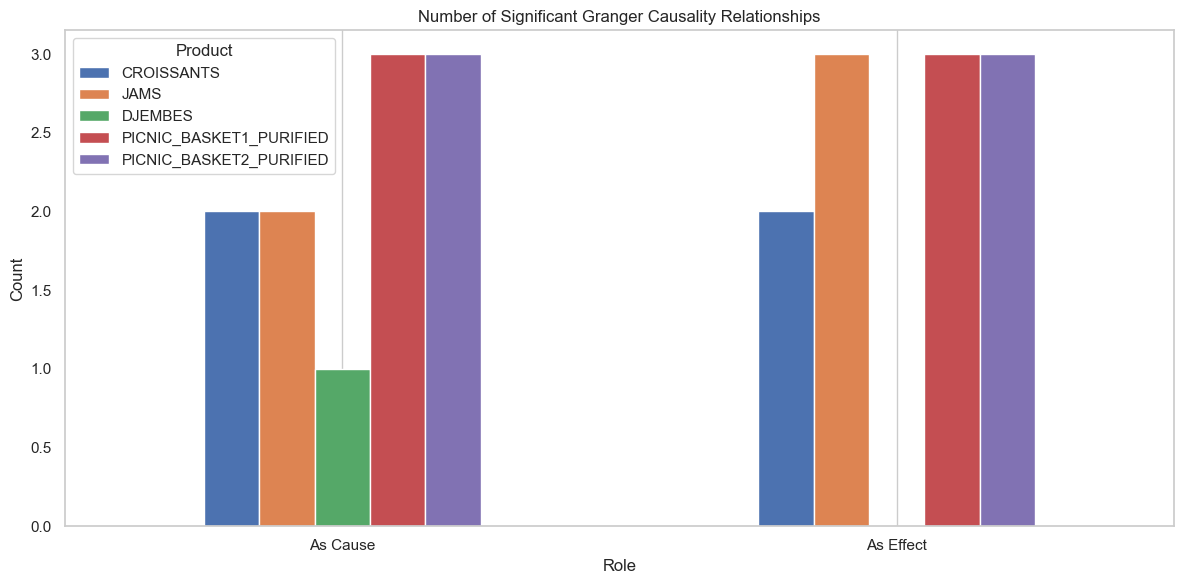

In [14]:
# Plot the counts
plt.figure(figsize=(12, 6))
counts_df.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Significant Granger Causality Relationships')
plt.xlabel('Role')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Product')
plt.grid(axis='y')
plt.tight_layout()
plt.show()